In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import scanpy as sc

In [2]:

import random
random.seed(0)

In [3]:
noise_file = "sim_g2_dropout_5"

obs_label_column = "Group"

adata = sc.read_h5ad(f"C:\\Users\\gmaho\\Desktop\\ai_masters_thesis\\simulated_datasets\\{noise_file}.h5ad")

In [4]:
adata

obs_col_name = "Group"
feature_col_name = "Gene"

In [5]:
sim_raw = adata

y = np.array(adata.obs[obs_label_column])

sim_true = sc.AnnData(adata.layers["TrueCounts"],obs=pd.DataFrame(y, columns=[obs_label_column]))

sc.pp.filter_genes(sim_raw, min_counts=1)

sim_raw_norm = sim_raw.copy()
sc.pp.normalize_total(sim_raw_norm)
sc.pp.log1p(sim_raw_norm)
sc.pp.pca(sim_raw_norm)

D:\Program Files\Python311\Lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [6]:
sim_raw_norm

AnnData object with n_obs × n_vars = 2000 × 195
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'n_counts'
    uns: 'X_name', 'log1p', 'pca'
    obsm: 'UMAP', 'X_pca'
    varm: 'PCs'
    layers: 'BCV', 'BaseCellMeans', 'BatchCellMeans', 'CellMeans', 'DropProb', 'Dropout', 'TrueCounts', 'logcounts'

In [7]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation,BatchNormalization,GaussianNoise
from keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras.layers import LeakyReLU,Reshape
import keras_tuner as kt
import tensorflow as tf


Using TensorFlow backend


In [8]:
def build_encoder(input_shape,hl1,hl2,hl3):
    # Encoder

    inputs = Input( shape=(input_shape,) )

    
    x = Dense(hl1)(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(hl2)(x)
    x = LeakyReLU(alpha=0.2)(x)
    mean = Dense(hl3)(x)
    var = Dense(hl3)(x)
    latent_layer = tf.keras.layers.Add()([mean, var])


    return Model(inputs, latent_layer)


In [9]:
def build_decoder(input_shape,hl1,hl2,hl3):
        
        model = Sequential()

        model.add(Dense(hl2, input_dim=hl3))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(hl1))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(np.prod((input_shape,)), activation='relu'))
        model.add(Reshape((input_shape,)))

        model.summary()

        z = Input(shape=(hl3,))
        expr_lat = model(z)

        return Model(z, expr_lat)

In [10]:
def build_discriminator(input_shape,hl1,hl2,hl3):

        model = Sequential()

        model.add(Dense(hl2, input_dim=hl3))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation="relu"))
        model.summary()

        encoded_repr = Input(shape=(hl3, ))
        validity = model(encoded_repr)

        return Model(encoded_repr, validity)


In [11]:
input_shape=195
latent_dim = 32

hl1=128
hl2=64
hl3=latent_dim

batch_size = 16
n_epochs = 20
x = sim_raw_norm.X
activation='relu'

In [12]:
# Implementation as per DB-AAE paper
class AEHyperModel(kt.HyperModel):
  
  def build(self, hp):
    hp_n2 = hp.Int('units_2', min_value=64, max_value=128, step=32)
    hp_n3 = hp.Int('units_3', min_value=32, max_value=64, step=16)
    hp_n4 = hp.Int('units_4', min_value=16, max_value=32, step=16)

    # Build the encoder / decoder
    encoder = build_encoder(input_shape,hl1,hl2,hl3)
    decoder = build_decoder(input_shape,hl1,hl2,hl3) 

    optimizer = RMSprop(learning_rate=0.00002)

    discriminator = build_discriminator(input_shape,hl1,hl2,hl3)
    discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    
    autoencoder_input = Input(shape=(input_shape,))
    
    reconstructed_input = Input(shape=(input_shape,))
    
    encoded_repr = encoder(autoencoder_input)
    reconstructed = decoder(encoded_repr)
    
    discriminator.trainable = False

    # The discriminator determines validity of the encoding
    validity = discriminator(encoded_repr)
    

    # The adversarial_autoencoder model  (stacked generator and discriminator)
    adversarial_autoencoder = Model(autoencoder_input, [reconstructed, validity])
    
   
    adversarial_autoencoder.compile(optimizer=optimizer,loss=['mse', 'binary_crossentropy'],loss_weights=[0.999, 0.001])
    return adversarial_autoencoder
    
  def fit(self, hp, adversarial_autoencoder, *args, **kwargs):
    batch_size=hp.Int('batch_size', min_value = 16, max_value = 128, step = 16)
    encoder = build_encoder(input_shape,hl1,hl2,hl3)
    decoder = build_decoder(input_shape,hl1,hl2,hl3)
    
    discriminator = build_discriminator(input_shape,hl1,hl2,hl3)
    optimizer = RMSprop(learning_rate=0.00002)
    
    discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    # For the adversarial_autoencoder model we will only train the generator
    discriminator.trainable = False
    
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for epoch in np.arange(1, n_epochs + 1):
        for i in range(int(len(x) / batch_size)):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            batch = x[i*batch_size:i*batch_size+batch_size]

    
            latent_fake = encoder.predict(batch)
            latent_real = np.random.normal(size=(batch_size, latent_dim))

            # Train the discriminator
            d_loss_real = discriminator.train_on_batch(latent_real, valid)
            d_loss_fake = discriminator.train_on_batch(latent_fake, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator
            g_loss = adversarial_autoencoder.train_on_batch(batch, [batch, valid])
       
    return 100*d_loss[1]

In [13]:
tuner = kt.Hyperband(AEHyperModel(),
                    objective = 'val_accuracy',
                    max_epochs = 10,
                    executions_per_trial = 1,
                    overwrite = True,
                     directory = './cache_gloom',
                     max_consecutive_failed_trials=5,
                    factor = 3)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 195)               25155     
                                                                 
 reshape (Reshape)           (None, 195)               0         
                                                                 
Total params: 35,587
Trainable params: 35,587
Non-traina

In [14]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', baseline=100)
tuner.search(x, x, epochs = 10, validation_split = 0.1, callbacks=[stop_early])

Trial 18 Complete [00h 00m 27s]
val_accuracy: 92.70833432674408

Best val_accuracy So Far: 100.0
Total elapsed time: 00h 13m 17s

Search: Running Trial #19

Value             |Best Value So Far |Hyperparameter
96                |64                |units_2
64                |48                |units_3
32                |16                |units_4
32                |16                |batch_size
4                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |0                 |tuner/round
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64)                0         
                                          

KeyboardInterrupt: 

In [15]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""

batch_size : {best_hps.get('batch_size')}
""")



batch_size : 16


In [16]:
#optimizer = Adam(0.0002, 0.5)
best_hps.get('batch_size')
optimizer = RMSprop(learning_rate=0.0002)
# Build and compile the discriminator
discriminator = build_discriminator(input_shape,hl1,hl2,hl3)
discriminator.compile(loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])

# Build the encoder / decoder
encoder = build_encoder(input_shape,hl1,hl2,hl3)
decoder = build_decoder(input_shape,hl1,hl2,hl3)

autoencoder_input = Input(shape=(input_shape,))
reconstructed_input = Input(shape=(input_shape,))
        # The generator takes the image, encodes it and reconstructs it
        # from the encoding
encoded_repr = encoder(autoencoder_input)
reconstructed = decoder(encoded_repr)

# For the adversarial_autoencoder model we will only train the generator
discriminator.trainable = False

# The discriminator determines validity of the encoding
validity = discriminator(encoded_repr)

# The adversarial_autoencoder model  (stacked generator and discriminator)
adversarial_autoencoder = Model(autoencoder_input, [reconstructed, validity])
adversarial_autoencoder.compile(loss=['binary_crossentropy', 'binary_crossentropy'],
            loss_weights=[0.999, 0.001],
            optimizer=optimizer)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                2112      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 256)               16640     
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 1)                 257       
                                                                 
Total params: 19,009
Trainable params: 19,009
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
____________________________

In [17]:
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in np.arange(1, n_epochs + 1):
    for i in range(int(len(x) / batch_size)):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
        batch = x[i*batch_size:i*batch_size+batch_size]

    
        latent_fake = encoder.predict(batch)
        latent_real = np.random.normal(size=(batch_size, latent_dim))

            # Train the discriminator
        d_loss_real = discriminator.train_on_batch(latent_real, valid)
        d_loss_fake = discriminator.train_on_batch(latent_fake, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator
        g_loss = adversarial_autoencoder.train_on_batch(batch, [batch, valid])

            # Plot the progress
    print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))

1/1 [==============================] - 0s 16ms/step
1 [D loss: 0.003286, acc: 100.00%] [G loss: -4.722260, mse: -4.742426]
1/1 [==============================] - 0s 18ms/step
2 [D loss: 0.000000, acc: 100.00%] [G loss: -5.992255, mse: -6.013693]
1/1 [==============================] - 0s 13ms/step
3 [D loss: 0.000000, acc: 100.00%] [G loss: -6.189657, mse: -6.211293]
1/1 [==============================] - 0s 23ms/step
4 [D loss: 0.000000, acc: 100.00%] [G loss: -6.276639, mse: -6.298361]
1/1 [==============================] - 0s 25ms/step
5 [D loss: 0.000000, acc: 100.00%] [G loss: -6.343112, mse: -6.364902]
1/1 [==============================] - 0s 22ms/step
6 [D loss: 0.000000, acc: 100.00%] [G loss: -6.360910, mse: -6.382717]
1/1 [==============================] - 0s 14ms/step
7 [D loss: 0.000000, acc: 100.00%] [G loss: -6.331198, mse: -6.352976]
1/1 [==============================] - 0s 15ms/step
8 [D loss: 0.000000, acc: 100.00%] [G loss: -6.431882, mse: -6.453760]
1/1 [===========

In [18]:
adversarial_autoencoder.summary()


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 195)]        0           []                               
                                                                                                  
 model_8 (Functional)           (None, 32)           37504       ['input_12[0][0]']               
                                                                                                  
 model_9 (Functional)           (None, 195)          35587       ['model_8[0][0]']                
                                                                                                  
 model_7 (Functional)           (None, 1)            19009       ['model_8[0][0]']                
                                                                                           

In [20]:
output = adversarial_autoencoder.predict(x)

63/63 [==============================] - 0s 726us/step


In [21]:
sim_raw_norm.obs.Group

Cell1       Group1
Cell2       Group1
Cell3       Group2
Cell4       Group1
Cell5       Group1
             ...  
Cell1996    Group2
Cell1997    Group2
Cell1998    Group2
Cell1999    Group2
Cell2000    Group1
Name: Group, Length: 2000, dtype: category
Categories (2, object): ['Group1', 'Group2']

In [22]:
sim_raw_norm.var.Gene

Gene1        Gene1
Gene2        Gene2
Gene3        Gene3
Gene4        Gene4
Gene5        Gene5
            ...   
Gene196    Gene196
Gene197    Gene197
Gene198    Gene198
Gene199    Gene199
Gene200    Gene200
Name: Gene, Length: 195, dtype: object

In [23]:
adata_denoised = sc.AnnData(output[0],obs=pd.DataFrame(sim_raw_norm.obs.Group),var=pd.DataFrame(sim_raw_norm.var.Gene))

In [24]:
sc.pp.normalize_total(adata_denoised)
sc.pp.log1p(adata_denoised)
sc.pp.pca(adata_denoised)

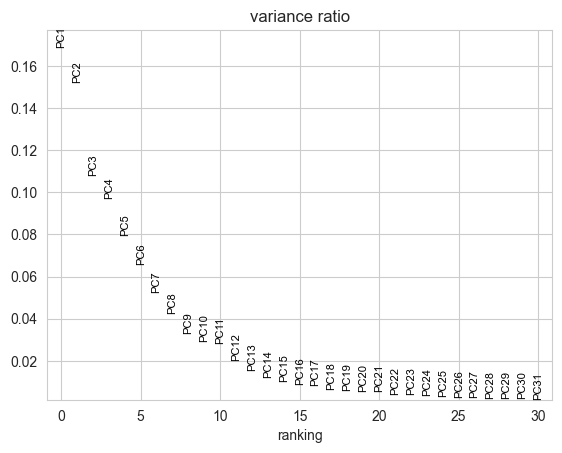

In [25]:
sc.pl.pca_variance_ratio(adata_denoised)

D:\Program Files\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


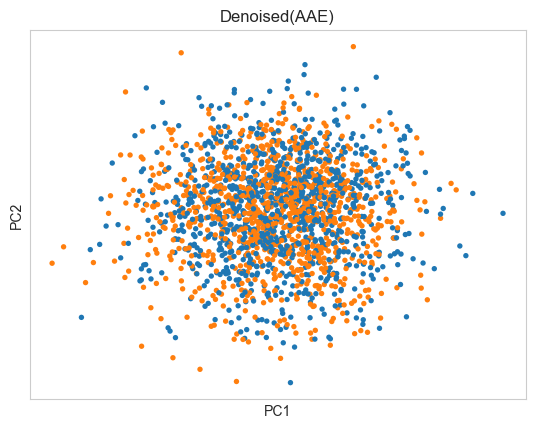

In [26]:
sc.pl.pca(adata_denoised, color='Group',title='Denoised(AAE)', legend_loc="")